Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick


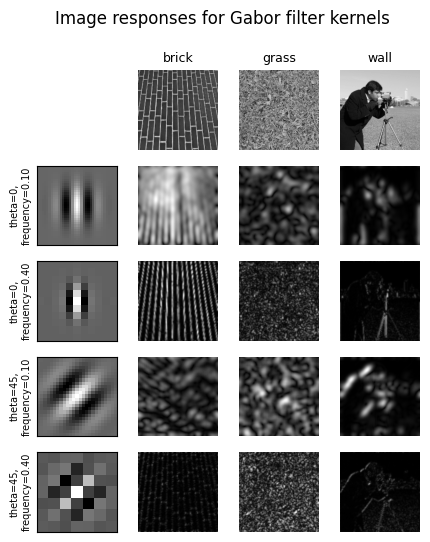

In [ ]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as nd
import skimage as ski
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(ski.data.brick())[shrink]
grass = img_as_float(ski.data.grass())[shrink]
wall = img_as_float(ski.data.camera())[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(wall, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(nd.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(nd.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(nd.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


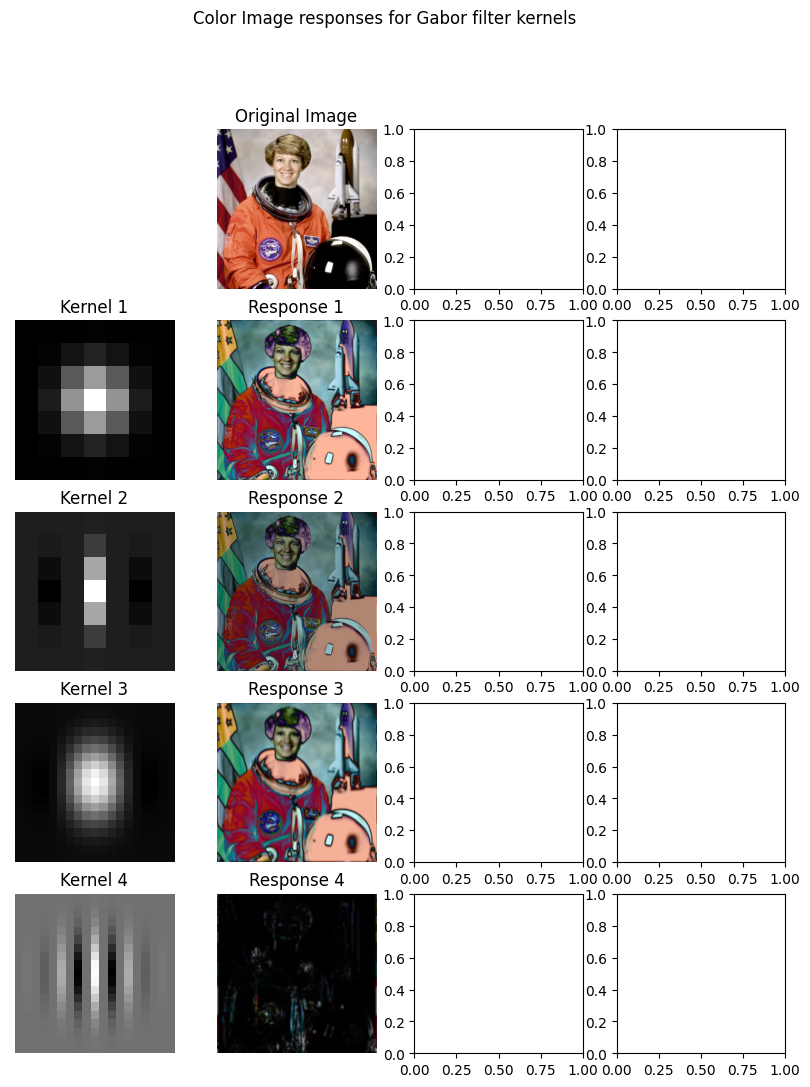

In [10]:
from sklearn.preprocessing import MinMaxScaler

def compute_color_feats(image, kernels):
    feats = np.zeros((len(kernels), 2, 3), dtype=np.double)
    for k, kernel in enumerate(kernels):
        for c in range(3):  # Assuming the image has 3 color channels
            filtered = nd.convolve(image[:, :, c], kernel, mode='wrap')
            feats[k, 0, c] = filtered.mean()
            feats[k, 1, c] = filtered.var()
    
    # Scale the features to be within 0-1
    scaler = MinMaxScaler()
    feats = scaler.fit_transform(feats.reshape(-1, 6)).reshape(len(kernels), 2, 3)
    return feats

def power_color(image, kernel):
    # Normalize images for better comparison.
    power_image = np.zeros_like(image)
    for c in range(3):  # Assuming the image has 3 color channels
        channel = image[:, :, c]
        channel = (channel - channel.mean()) / channel.std()
        power_image[:, :, c] = np.sqrt(nd.convolve(channel, np.real(kernel), mode='wrap')**2 +
                                       nd.convolve(channel, np.imag(kernel), mode='wrap')**2)
    
    # Scale the power image to be within 0-1
    scaler = MinMaxScaler()
    power_image = scaler.fit_transform(power_image.reshape(-1, 3)).reshape(image.shape)
    return power_image

# Load a sample color image
color_image = ski.data.astronaut()
color_image = img_as_float(color_image)

# Compute features for the color image
color_feats = compute_color_feats(color_image, kernels)

# Apply Gabor kernels to the color image
color_results = []
for kernel in kernels:
    color_results.append(power_color(color_image, kernel))

# Display the original color image and the Gabor responses
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 12))
fig.suptitle('Color Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')
axes[0][1].imshow(color_image)
axes[0][1].set_title('Original Image')
axes[0][1].axis('off')

for i, (kernel, power_image) in enumerate(zip(kernels[:4], color_results[:4])):
    axes[i+1][0].imshow(np.real(kernel), interpolation='nearest', cmap='gray')
    axes[i+1][0].set_title(f'Kernel {i+1}')
    axes[i+1][0].axis('off')
    axes[i+1][1].imshow(power_image)
    axes[i+1][1].set_title(f'Response {i+1}')
    axes[i+1][1].axis('off')

plt.show()


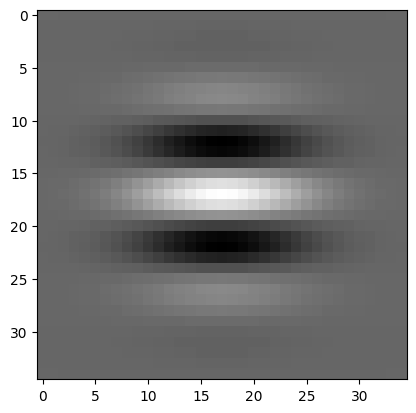

In [18]:
plt.imshow(np.real(gabor_kernel(0.1, theta = 1.57)))